In [64]:
## Imports
import os, sys
import time
import yaml
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from cGANtools.GAN import CGAN
#from keras.models import load_model
from scipy.cluster.hierarchy import linkage, dendrogram
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)
import helper as hp

### Slice of life functions

In [58]:
def load_and_generate(gen, d_scaling, ss_idx, n_samples, noise = []):
    
    sampled_labels = np.ones(n_samples).reshape(-1, 1) * cond_class  # sample conditional labels
    if len(noise)==0:
        noise = np.random.normal(0, 1, (n_samples, 127))             # generate random noise
        
    gen_par = gen.predict([noise, sampled_labels])                   # generate parameters
    
    # rescale parameters
    x_new, new_min, new_max = hp.unscale_range(gen_par, -1.0, 1.0, d_scaling['min_x'], d_scaling['max_x'])
    
    return x_new, noise

### Fixed parameters

In [59]:
ss_idx = 2
ix = 13
latent_dim = 127
cond_class = 1

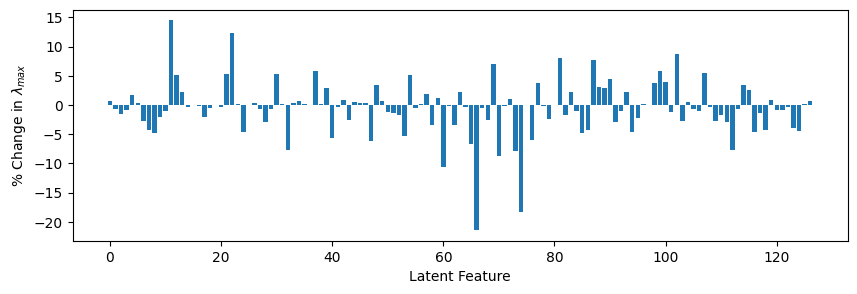

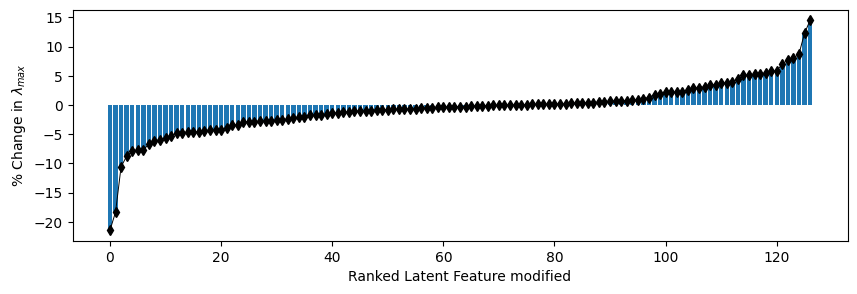

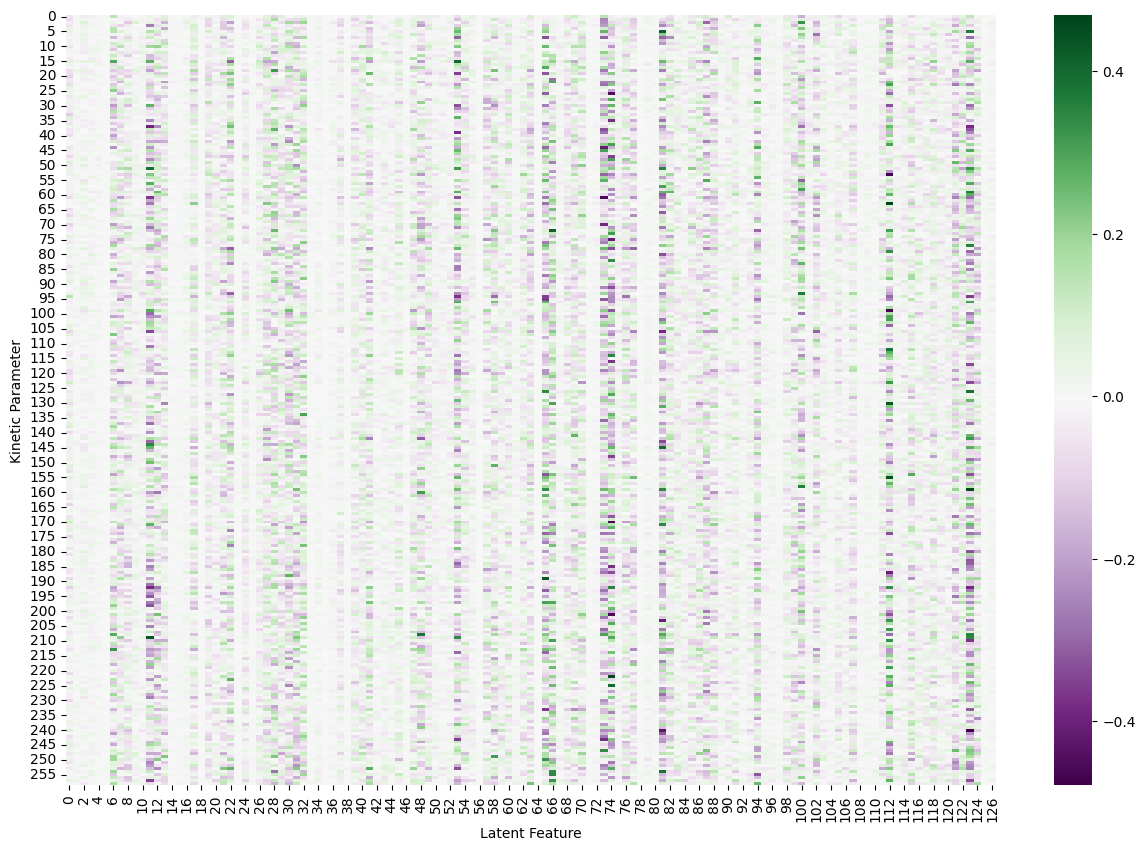

/home/subham/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/subham/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1500x1000 with 0 Axes>

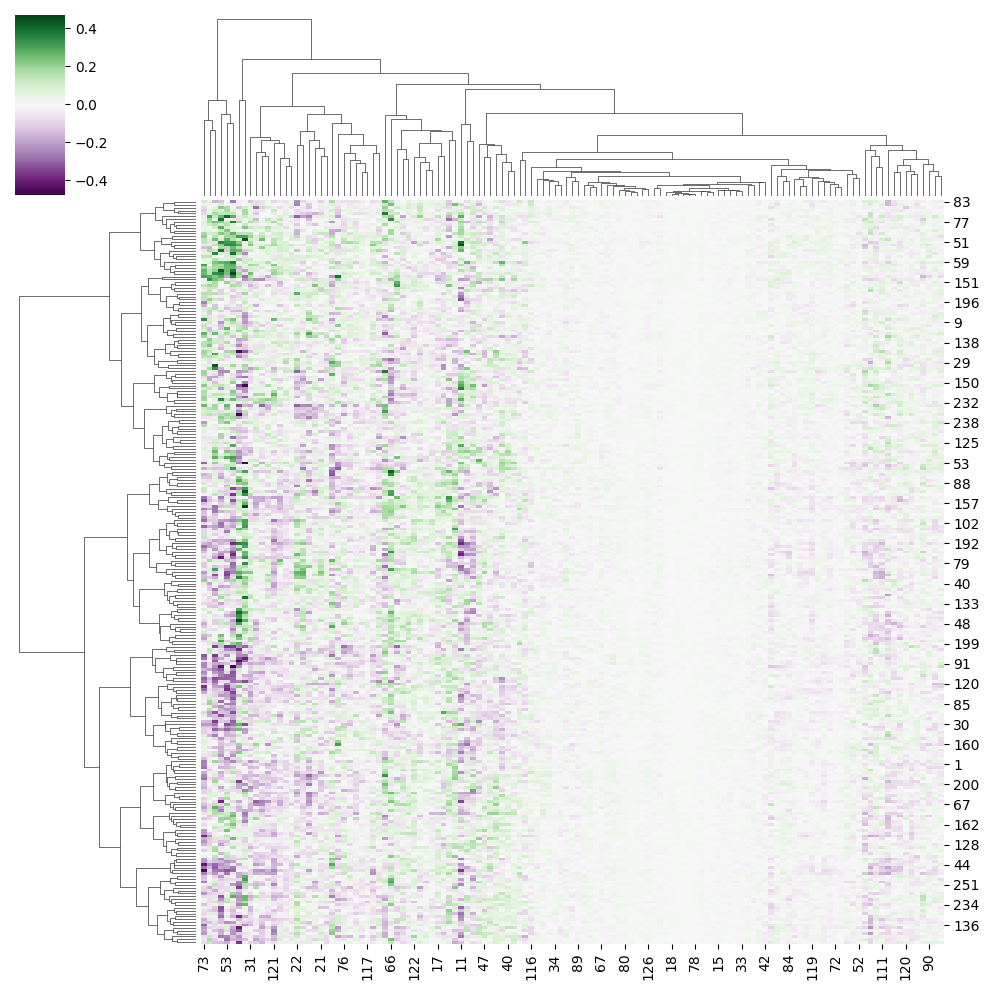

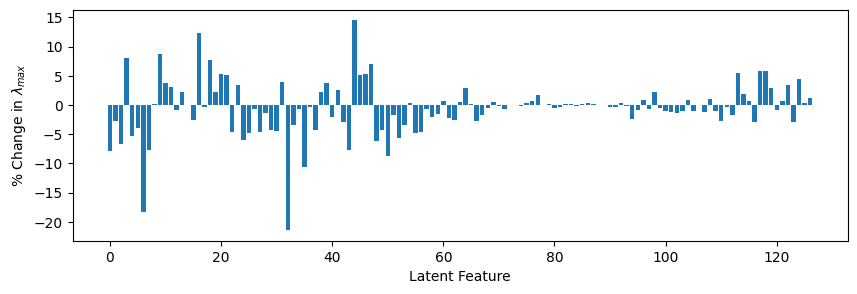

In [62]:
sample_eigenvals = pd.read_csv(f'analysis/{ss_idx}/sample_max_eig.csv').iloc[:,1].values 
sample_noise = np.load(f'analysis/{ss_idx}/sample_noise.npy')
sample = np.load(f'analysis/{ss_idx}/sample.npy')
ixs = pd.read_csv(f'analysis/{ss_idx}/ixs.csv').iloc[:,1].values

    
perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/perturbation/{ix}/max_eig.csv').iloc[:,1].values
seed_eig = sample_eigenvals[ix]

pc_change = ((seed_eig-perturbed_eigs)/seed_eig)*100

plt.figure(figsize = (10,3))
plt.bar(np.arange(latent_dim),pc_change)
plt.ylabel(r'% Change in $\lambda_{max}$')
plt.xlabel('Latent Feature')

plot_path = 'figures/figure_2/'
os.makedirs(plot_path, exist_ok = True)
plt.savefig(f'{plot_path}/all_features_unranked.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/all_features_unranked.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()


plt.figure(figsize = (10,3))
plt.bar(np.arange(latent_dim),sorted(pc_change))
plt.plot(np.arange(latent_dim), sorted(pc_change), 'kd-', ms = 5, lw = 0.7)
plt.ylabel(r'% Change in $\lambda_{max}$')
plt.xlabel('Ranked Latent Feature modified')

os.makedirs(plot_path, exist_ok = True)
plt.savefig(f'{plot_path}/all_features_ranked.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/all_features_ranked.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()


perturbed_params = np.load(f'analysis/{ss_idx}/perturbation/{ix}/perturbed_params.npy')
seed_params = sample[ix]
unravel_params = np.array([this_param[0] for this_param in perturbed_params])
pc_change_kms = []
for this_set in range(latent_dim):
    perturbed_km = (unravel_params[this_set] - seed_params)#/seed_params)*100
    pc_change_kms.append(perturbed_km)

plt.figure(figsize = (15,10))
sns.heatmap(np.transpose(pc_change_kms), cmap = 'PRGn')
plt.ylabel('Kinetic Parameter')
plt.xlabel('Latent Feature')

os.makedirs(plot_path, exist_ok = True)
plt.savefig(f'{plot_path}/km_changes.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/km_changes.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()

# Create heatmap with dendrograms
plt.figure(figsize = (15,10))
cluster_map = sns.clustermap(np.transpose(pc_change_kms), method='ward', cmap='PRGn', dendrogram_ratio=(0.1, 0.1))
os.makedirs(plot_path, exist_ok = True)
plt.savefig(f'{plot_path}/km_changes_clustered.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/km_changes_clustered.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()


# Cluster order
km_features = cluster_map.dendrogram_row.reordered_ind  # Row indices after clustering
latent_features = cluster_map.dendrogram_col.reordered_ind  # Column indices after clustering
plot_path = 'figures/figure_2/'


plt.figure(figsize = (10,3))
plt.bar(np.arange(latent_dim),pc_change[latent_features])
plt.ylabel(r'% Change in $\lambda_{max}$')
plt.xlabel('Latent Feature')

plot_path = 'figures/figure_2/'
os.makedirs(plot_path, exist_ok = True)
plt.savefig(f'{plot_path}/all_features_unranked.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/all_features_unranked.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()
plt.close()

/home/subham/miniconda3/lib/python3.8/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


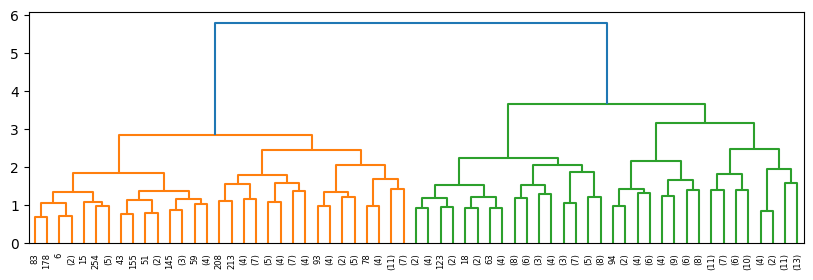

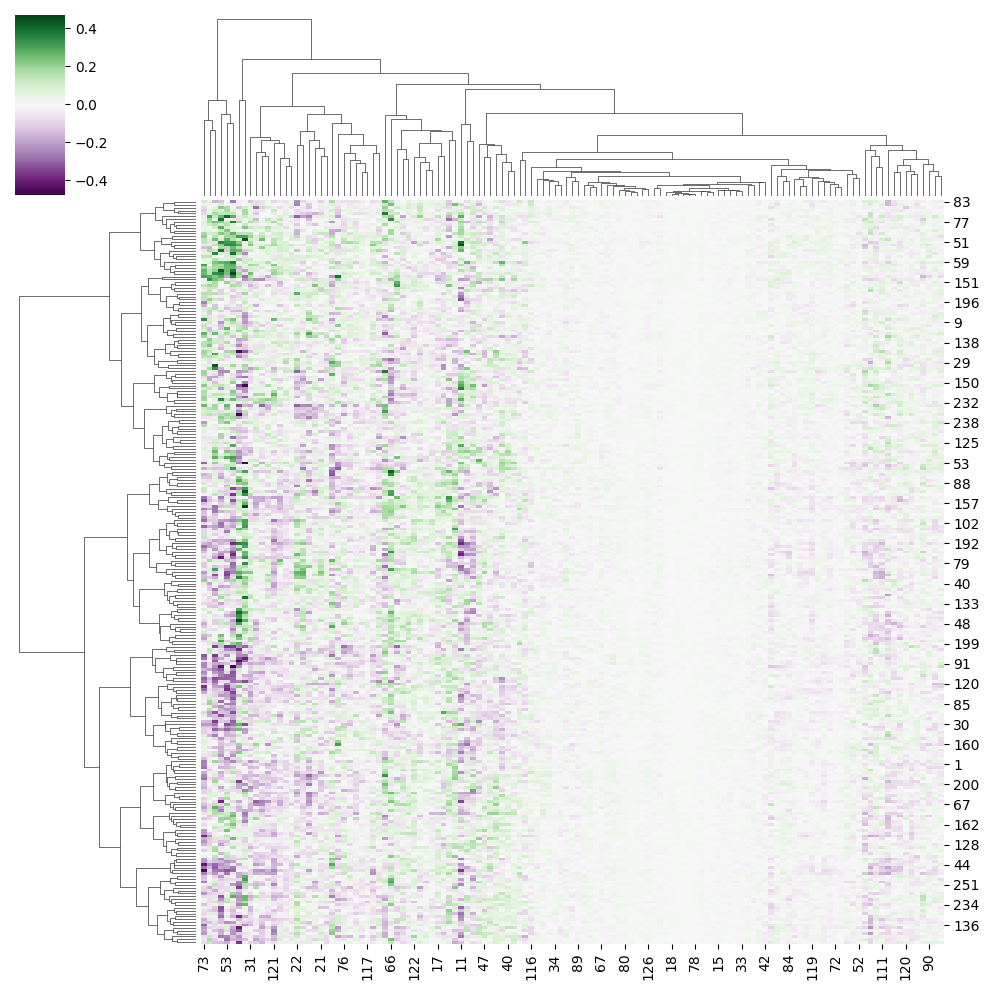

In [84]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute linkage
linkage_matrix = linkage(np.transpose(pc_change_kms), method='ward')

# Plot a simplified dendrogram (optional for testing)
plt.figure(figsize = (10,3))
dendrogram(linkage_matrix, truncate_mode='level', p=5)  # Adjust 'p' to change depth
plt.savefig(f'{plot_path}/dendo_columns.svg', dpi=300, transparent=False, bbox_inches='tight')

# Pass the linkage matrix with fewer levels to clustermap
sns.clustermap(
    np.transpose(pc_change_kms),
    row_linkage=linkage_matrix,
    method='ward',
    cmap='PRGn'
)

plt.show()


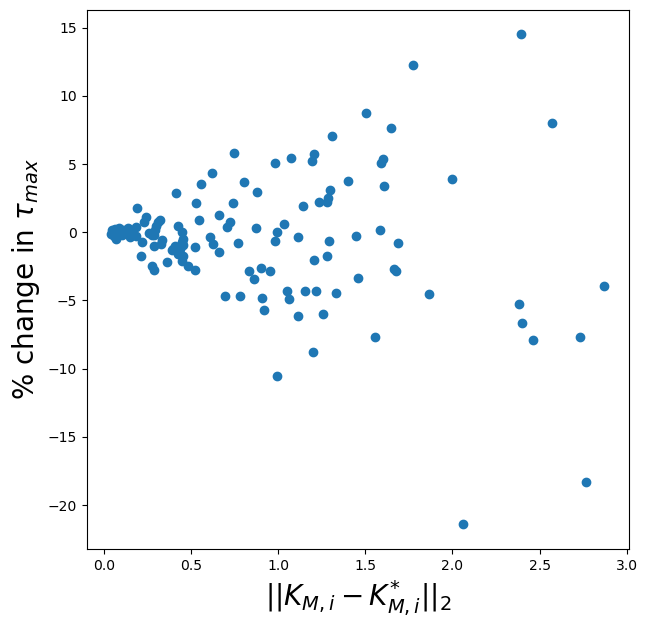

In [178]:
L2_kms = []
for this_set in perturbed_params:
    this_rmse = []
    for i in range(259):
        this_rmse.append((seed_params[i]-this_set[0][i])**2)
    L2_kms.append(np.sqrt(np.sum(this_rmse)))
plot_path = 'figures/supplementary'
plt.figure(figsize = (7,7))
plt.scatter(L2_kms, pc_change)
plt.ylabel(r'% change in $\tau_{max}$', fontsize = 20)
plt.xlabel('$||K_{M,i} - K^{*}_{M,i}||_{2}$', fontsize = 20)
plt.savefig(f'{plot_path}/tau_vs_l2.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/tau_vs_l2.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

### Perturbation of latent features by different magnitudes and directions

In [179]:
# Load generator and scaling factors

# path to generator
path_to_generator = f'best_generators/best_generator_{ss_idx}.h5'
gen = load_model(path_to_generator)
# Load scaling parameters
path_to_data_scaling = f'best_generators/d_scaling_{ss_idx}'
d_scaling = hp.load_pkl(path_to_data_scaling)

sample_noise = np.load(f'analysis/{ss_idx}/sample_noise.npy')
dummy_noise = sample_noise.copy()

perturbed_params = []
perturbed_noise = []
seed_noise = dummy_noise[ix]

for this_feature in range(latent_dim):
    
    # Make a copy of the original seed_noise to reset it for each feature perturbation
    temp_noise = seed_noise.copy()

    # Increase feature by 50%
    og_feature = temp_noise[this_feature].copy()
    new_feature = og_feature * (1 + perturbance)
    temp_noise[this_feature] = new_feature 

    # Now generate with modified feature
    new_param, new_noise = load_and_generate(gen, d_scaling, ss_idx, 1, np.array([list(temp_noise)]))
    
    perturbed_params.append(new_param)
    perturbed_noise.append(new_noise)

# Save new noise and parameters
savepath = f'analysis/{ss_idx}/extra_data/'
os.makedirs(savepath, exist_ok=True)
    
np.save(f'{savepath}/perturbed_params_{perturbance}.npy', perturbed_params)
np.save(f'{savepath}/perturbed_noise_{perturbance}.npy', perturbed_noise)

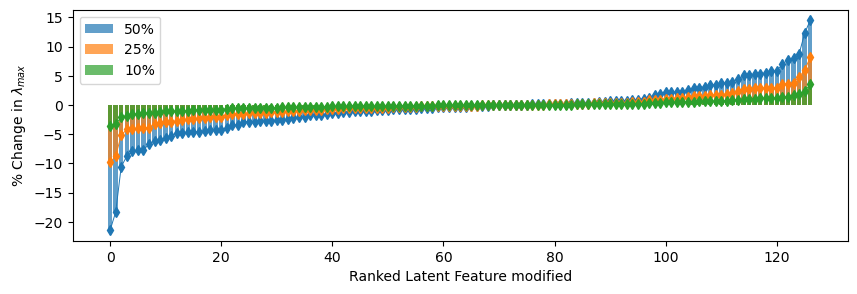

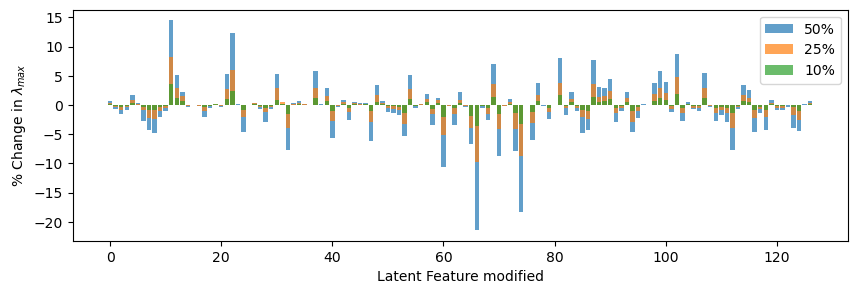

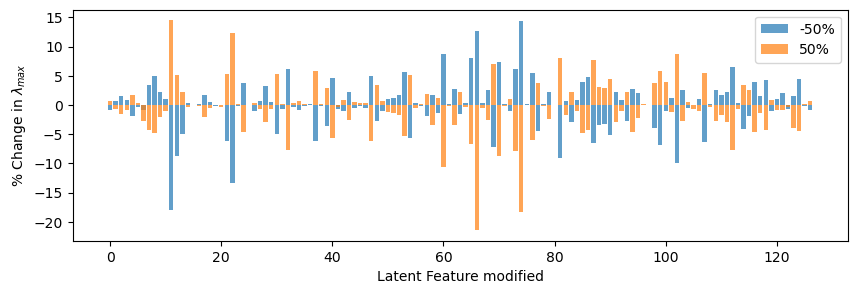

In [180]:
plt.figure(figsize = (10,3))
for perturbance in [0.5, 0.25, 0.1]:    
    perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/extra_data/max_eig_{perturbance}.csv').iloc[:,1].values
    seed_eig = sample_eigenvals[ix]
    pc_change = ((seed_eig-perturbed_eigs)/seed_eig)*100
    plt.bar(np.arange(latent_dim),sorted(pc_change), label = f'{int(perturbance*100)}%', alpha = 0.7)
    plt.plot(np.arange(latent_dim), sorted(pc_change), 'd-', ms = 5, lw = 0.7)

plt.ylabel(r'% Change in $\lambda_{max}$')
plt.xlabel('Ranked Latent Feature modified')
plt.legend()

plt.savefig(f'{plot_path}/ranked_diff_perturb.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/ranked_diff_perturb.png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()
plt.close()

plt.figure(figsize = (10,3))
for perturbance in [0.5, 0.25, 0.1]:    
    perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/extra_data/max_eig_{perturbance}.csv').iloc[:,1].values
    seed_eig = sample_eigenvals[ix]
    pc_change = ((seed_eig-perturbed_eigs)/seed_eig)*100
    plt.bar(np.arange(latent_dim),pc_change, label = f'{int(perturbance*100)}%', alpha = 0.7)

plt.ylabel(r'% Change in $\lambda_{max}$')
plt.xlabel('Latent Feature modified')
plt.legend()

plt.savefig(f'{plot_path}/diff_perturb.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/diff_perturb.png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()
plt.close()

plt.figure(figsize = (10,3))
for perturbance in [-0.5, 0.5]:    
    perturbed_eigs = pd.read_csv(f'analysis/{ss_idx}/extra_data/max_eig_{perturbance}.csv').iloc[:,1].values
    seed_eig = sample_eigenvals[ix]
    pc_change = ((seed_eig-perturbed_eigs)/seed_eig)*100
    plt.bar(np.arange(latent_dim),pc_change, label = f'{int(perturbance*100)}%', alpha = 0.7)

plt.ylabel(r'% Change in $\lambda_{max}$')
plt.xlabel('Latent Feature modified')
plt.legend()

plt.savefig(f'{plot_path}/opp_perturb.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/opp_perturb.png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()
plt.close()

## Visualize non-linear integration responses

### 1. Filter interesting linear responses

In [32]:
path_to_max_eigs = f'analysis/{ss_idx}/latent_heatmap/{ix}/max_eig_2.csv'
max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values

sorted_lst = sorted(enumerate(max_eigs), key=lambda x: (-x[1], -x[0]))
sorted_max_eigs = [x[1] for x in sorted_lst]
sorted_max_eigs_ix = [x[0] for x in sorted_lst]

n_models = 30

# get fastest model indexes
fastest_ixs = sorted_max_eigs_ix[-n_models:]

# get model indexes with similar eigenvalues as seed model
tolerance = 0.01
up_lim, low_lim = seed_eig*(1-tolerance), seed_eig*(1+tolerance)
moderate_ixs = [i for i, value in enumerate(max_eigs) if low_lim < value < up_lim]
print(len(moderate_ixs))

# get slowest model indexes
first_stable_ix = np.where((np.array(sorted_max_eigs)>0)==True)[0][-1]
slowest_ixs = sorted_max_eigs_ix[first_stable_ix+1:first_stable_ix+1+n_models]

all_ixs = []
for this_ixs in [fastest_ixs, moderate_ixs, slowest_ixs]:
    for this_ix in this_ixs: all_ixs.append(this_ix)

pd.DataFrame(all_ixs).to_csv(f'analysis/{ss_idx}/latent_heatmap/{ix}/interesting_indexes.csv')

21


### 2. Visualize interesting responses

1. Biomass Flux

fast: percentage of valid models: 60.0
fast: time for settling: 7.88 mins
no change: percentage of valid models: 52.38095238095238
no change: time for settling: 11.92 mins
slow: percentage of valid models: 26.666666666666668
slow: time for settling: 522.51 mins


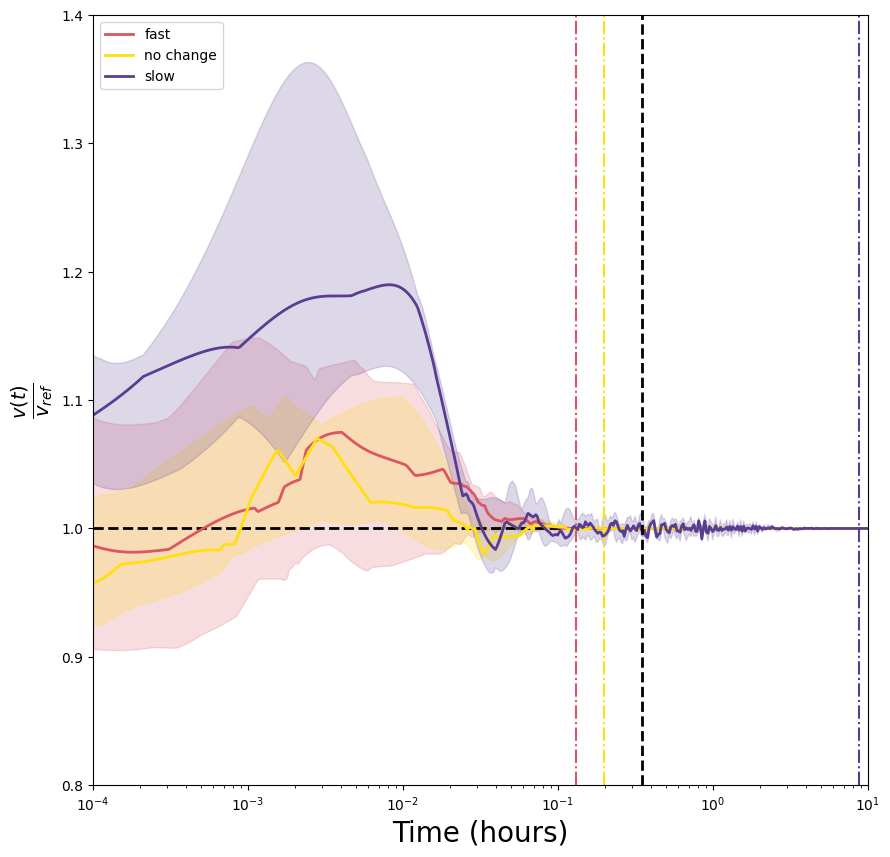

In [56]:
tol = 0.001
T = np.logspace(-9, 1, 1000)
labels = ['fast','no change','slow']
coolors = ['#DB5562', '#FFE00C', '#593D90']

plt.figure(figsize = (10,10))

plt.axhline(y = 1, ls = '--', color = 'k', lw = 2)
path_to_ode_solutions = f'analysis/{ss_idx}/latent_heatmap/{ix}/ode_output/latent_heatmap_soln/'
v_ref = 0.000674332689731 # from steady state profile
for this_cool, this_label,these_ixs in zip(coolors, labels, [fastest_ixs, moderate_ixs, slowest_ixs]):
    all_biomass = []
    viable_models = 0
    for this_ix in these_ixs:
        this_solution = pd.read_csv(f'{path_to_ode_solutions}fluxes_{this_ix}.csv')
        soln = this_solution['LMPD_biomass_c_17_462'].values/v_ref
        if round(soln[-1]) == 1:
            all_biomass.append(this_solution['LMPD_biomass_c_17_462'].values/v_ref)
            #plt.plot(T, soln, color = this_cool)
            viable_models+=1
    print(f'{this_label}: percentage of valid models: {viable_models*100/len(these_ixs)}')
    all_biomass = np.array(all_biomass)
    plt.plot(T, np.median(all_biomass, axis = 0), label = this_label, c = this_cool, lw = 2)
    plt.fill_between(T,  np.percentile(all_biomass, 25, axis = 0),  np.percentile(all_biomass, 75, axis = 0), color = this_cool, alpha = 0.2)
    
    ix_max = np.where(np.max(all_biomass, axis = 0)<1+tol)[0]
    ix_min = np.where(np.min(all_biomass, axis = 0)>1-tol)[0]
    ix_for_vertical = np.intersect1d(ix_max, ix_min)[0]
    plt.axvline(T[ix_for_vertical], color = this_cool, ls = '-.')
    print(f'{this_label}: time for settling: {np.round(T[ix_for_vertical]*60,2)} mins')
plt.xscale('log')
plt.xlim([1e-4, 10])
plt.axvline(21/60, color = 'k', ls = '--', lw = 2)
plt.ylim([0.8, 1.4])
plt.xlabel(f'Time (hours)', fontsize = 20)
plt.ylabel(r'$\frac{v(t)}{v_{ref}}$', fontsize = 20)
plt.legend()

plot_path = 'figures/figure_2'

plt.savefig(f'{plot_path}/ODE_biomass_latent.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/ODE_biomass_latent.png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()

fast: percentage of valid models: 60.0
fast: time for settling: 7.88 mins
no change: percentage of valid models: 52.38095238095238
no change: time for settling: 11.92 mins
slow: percentage of valid models: 26.666666666666668
slow: time for settling: 522.51 mins


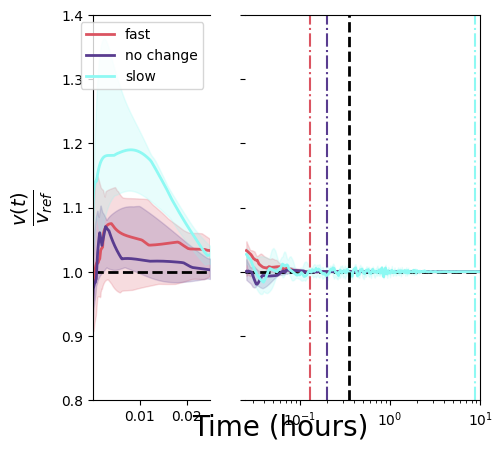

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tol = 0.001
T = np.logspace(-9, 1, 1000)  # Original time points
labels = ['fast', 'no change', 'slow']
coolors = ['#DB5461', '#593C8F', '#8EF9F3']

# Define threshold for switching between linear and log scale
threshold = 0.25e-1  # Adjust this value based on your data

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 5), gridspec_kw={'width_ratios': [1, 2]})

# Common horizontal line
ax1.axhline(y=1, ls='--', color='k', lw=2)
ax2.axhline(y=1, ls='--', color='k', lw=2)

path_to_ode_solutions = f'analysis/{ss_idx}/latent_heatmap/{ix}/ode_output/latent_heatmap_soln/'
v_ref = 0.000674332689731  # from steady state profile

for this_cool, this_label, these_ixs in zip(coolors, labels, [fastest_ixs, moderate_ixs, slowest_ixs]):
    all_biomass = []
    viable_models = 0
    
    for this_ix in these_ixs:
        this_solution = pd.read_csv(f'{path_to_ode_solutions}fluxes_{this_ix}.csv')
        soln = this_solution['LMPD_biomass_c_17_462'].values / v_ref
        if round(soln[-1]) == 1:
            all_biomass.append(soln)
            viable_models += 1

    print(f'{this_label}: percentage of valid models: {viable_models * 100 / len(these_ixs)}')
    
    all_biomass = np.array(all_biomass)
    
    # Split data for linear and log portions
    T_linear = T[T < threshold]
    T_log = T[T >= threshold]
    
    median_linear = np.median(all_biomass[:, T < threshold], axis=0)
    median_log = np.median(all_biomass[:, T >= threshold], axis=0)
    
    percentile_25_linear = np.percentile(all_biomass[:, T < threshold], 25, axis=0)
    percentile_75_linear = np.percentile(all_biomass[:, T < threshold], 75, axis=0)
    
    percentile_25_log = np.percentile(all_biomass[:, T >= threshold], 25, axis=0)
    percentile_75_log = np.percentile(all_biomass[:, T >= threshold], 75, axis=0)

    # Plot on linear axis
    ax1.plot(T_linear, median_linear, label=this_label, c=this_cool, lw=2)
    ax1.fill_between(T_linear, percentile_25_linear, percentile_75_linear, color=this_cool, alpha=0.2)

    # Plot on log axis
    ax2.plot(T_log, median_log, label=this_label, c=this_cool, lw=2)
    ax2.fill_between(T_log, percentile_25_log, percentile_75_log, color=this_cool, alpha=0.2)

    # Compute time for settling and draw vertical line
    ix_max = np.where(np.max(all_biomass, axis=0) < 1 + tol)[0]
    ix_min = np.where(np.min(all_biomass, axis=0) > 1 - tol)[0]
    ix_for_vertical = np.intersect1d(ix_max, ix_min)[0]

    if T[ix_for_vertical] < threshold:
        ax1.axvline(T[ix_for_vertical], color=this_cool, ls='-.')
    else:
        ax2.axvline(T[ix_for_vertical], color=this_cool, ls='-.')

    print(f'{this_label}: time for settling: {np.round(T[ix_for_vertical] * 60, 2)} mins')

# Adjust x-axis scales
ax1.set_xscale('linear')
ax1.set_xlim([1e-4, threshold])

ax2.set_xscale('log')
ax2.set_xlim([threshold, 10])

# Hide overlapping spines for a seamless transition
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Common labels
fig.text(0.5, 0.04, 'Time (hours)', ha='center', fontsize=20)
ax1.set_ylabel(r'$\frac{v(t)}{v_{ref}}$', fontsize=20)

ax2.axvline(21 / 60, color='k', ls='--', lw=2)
ax1.legend()

plt.ylim([0.8, 1.4])

# Save the figure
plot_path = 'figures/figure_2/'
plt.savefig(f'{plot_path}/ODE_biomass.svg', dpi=300, transparent=False, bbox_inches='tight')
plt.savefig(f'{plot_path}/ODE_biomass.png', dpi=300, transparent=False, bbox_inches='tight')

plt.show()
plt.close()


In [52]:
-60/np.linspace(-35,-5,7)

array([ 1.71428571,  2.        ,  2.4       ,  3.        ,  4.        ,
        6.        , 12.        ])

fast: percentage of valid models: 60.0
fast: time for settling: 10.38 mins
no change: percentage of valid models: 52.38095238095238
no change: time for settling: 14.67 mins
slow: percentage of valid models: 26.666666666666668
slow: time for settling: 534.69 mins


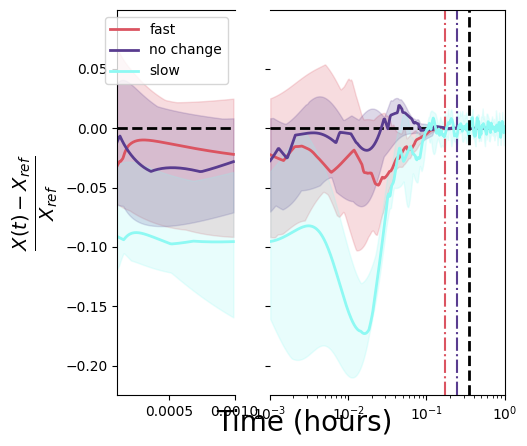

fast: percentage of valid models: 60.0
fast: time for settling: 5.97 mins
no change: percentage of valid models: 52.38095238095238
no change: time for settling: 7.7 mins
slow: percentage of valid models: 26.666666666666668
slow: time for settling: 44.36 mins


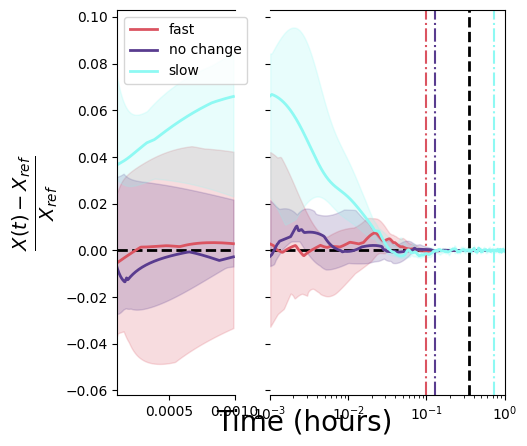

fast: percentage of valid models: 60.0
fast: time for settling: 9.04 mins
no change: percentage of valid models: 52.38095238095238
no change: time for settling: 11.92 mins
slow: percentage of valid models: 40.0
does not settle


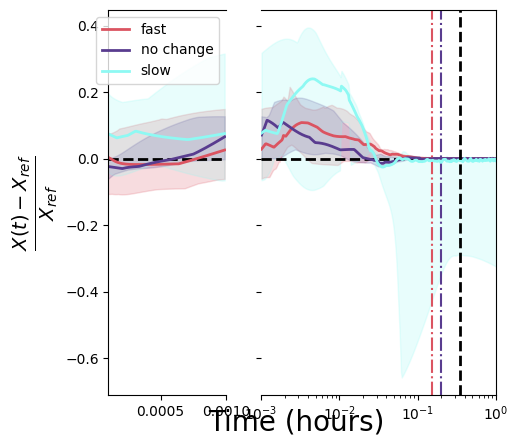

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

tol = 0.001
T = np.logspace(-9, 1, 1000)  # Time points
labels = ['fast', 'no change', 'slow']
coolors = ['#DB5461', '#593C8F', '#8EF9F3']

refs = [-6.12818325253493, -5.64929428937213, -13.5606128668308]
ids = ['atp_c', 'adp_c', 'nadp_c']
names = ['atp', 'adp', 'nadh']

# Define the threshold for linear-to-log transition
threshold = 1e-3  # Adjust as needed

for (v_ref, met_id, label_name) in zip(refs, ids, names):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(5, 5), gridspec_kw={'width_ratios': [1, 2]})
    
    # Common horizontal line
    ax1.axhline(y=0, ls='--', color='k', lw=2)
    ax2.axhline(y=0, ls='--', color='k', lw=2)
    
    path_to_ode_solutions = f'analysis/{ss_idx}/latent_heatmap/{ix}/ode_output/latent_heatmap_soln/'

    for this_cool, this_label, these_ixs in zip(coolors, labels, [fastest_ixs, moderate_ixs, slowest_ixs]):
        all_biomass = []
        viable_models = 0
        
        for this_ix in these_ixs:
            this_solution = pd.read_csv(f'{path_to_ode_solutions}solution_{this_ix}.csv')
            soln = this_solution[met_id].values
            
            if round(soln[-1]) == 0:
                all_biomass.append(soln)
                viable_models += 1
        
        print(f'{this_label}: percentage of valid models: {viable_models * 100 / len(these_ixs)}')
        
        all_biomass = np.array(all_biomass)
        
        # Split data for linear and log portions
        T_linear = T[T < threshold]
        T_log = T[T >= threshold]
        
        median_linear = np.median(all_biomass[:, T < threshold], axis=0)
        median_log = np.median(all_biomass[:, T >= threshold], axis=0)
        
        percentile_25_linear = np.percentile(all_biomass[:, T < threshold], 25, axis=0)
        percentile_75_linear = np.percentile(all_biomass[:, T < threshold], 75, axis=0)
        
        percentile_25_log = np.percentile(all_biomass[:, T >= threshold], 25, axis=0)
        percentile_75_log = np.percentile(all_biomass[:, T >= threshold], 75, axis=0)

        # Plot on linear axis
        ax1.plot(T_linear, median_linear, label=this_label, c=this_cool, lw=2)
        ax1.fill_between(T_linear, percentile_25_linear, percentile_75_linear, color=this_cool, alpha=0.2)

        # Plot on log axis
        ax2.plot(T_log, median_log, label=this_label, c=this_cool, lw=2)
        ax2.fill_between(T_log, percentile_25_log, percentile_75_log, color=this_cool, alpha=0.2)

        # Compute time for settling and draw vertical line
        ix_max = np.where(np.max(all_biomass, axis=0) < tol)[0]
        ix_min = np.where(np.min(all_biomass, axis=0) > -tol)[0]

        if ix_max.size == 0 or ix_min.size == 0:
            print('does not settle')
        else:
            ix_for_vertical = np.intersect1d(ix_max, ix_min)[0]

            if T[ix_for_vertical] < threshold:
                ax1.axvline(T[ix_for_vertical], color=this_cool, ls='-.')
            else:
                ax2.axvline(T[ix_for_vertical], color=this_cool, ls='-.')

            print(f'{this_label}: time for settling: {np.round(T[ix_for_vertical] * 60, 2)} mins')

    # Adjust x-axis scales
    ax1.set_xscale('linear')
    ax1.set_xlim([1e-4, threshold])

    ax2.set_xscale('log')
    ax2.set_xlim([threshold, 1])

    # Hide overlapping spines for a seamless transition
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    # Common labels
    fig.text(0.5, 0.04, 'Time (hours)', ha='center', fontsize=20)
    ax1.set_ylabel(r'$\frac{X(t)-X_{ref}}{X_{ref}}$', fontsize=20)

    ax2.axvline(21 / 60, color='k', ls='--', lw=2)
    ax1.legend()

    # Save the figure
    plot_path = 'figures/figure_3'
    
    plt.savefig(f'{plot_path}/ODE_{label_name}_latent.svg', dpi=300, transparent=False, bbox_inches='tight')
    plt.savefig(f'{plot_path}/ODE_{label_name}_latent.png', dpi=300, transparent=False, bbox_inches='tight')
    
    plt.show()
    plt.close()
